In [2]:
import gymnasium as gym 
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
class MultiArmedBanditEnv(gym.Env):
    def __init__(self, probs, T):
        """
        初始化多臂老虎机环境
        probs: 每个臂的成功概率
        T: 总时间步数
        """
        super(MultiArmedBanditEnv, self).__init__()
        self.k = len(probs)  # 臂的数量
        self.probs = probs  # 每个臂的成功概率
        self.T = T  # 总时间步数

        # 定义动作空间和观察空间
        self.action_space = spaces.Box(low=1, high=100, shape=(1,), dtype=np.float32)  # 动作空间为alpha\in[1,100]代指UCB算法中的探索因子
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3 * self.k + 1,))  # 观察空间为(3*k+1)维向量，每个维度包含三个元素：拉臂的次数、获得的奖励、奖励的方差，以及最后一个元素是时间t
        self.reset()

    def reset(self, seed=None, options=None):
        """
        重置环境
        返回: 初始状态
        """
        super().reset(seed=seed)
        self.steps = 0
        self.n = np.zeros(self.k)  # 每个臂的拉动次数
        self.average_rewards = np.zeros(self.k)  # 每个臂奖励的均值
        self.rewards = [[] for _ in range(self.k)]  # 每个臂的奖励列表
        self.var = np.zeros(self.k) # 每个臂奖励的方差
        self.alpha = 1.0  # 初始alpha值
        observation = np.zeros(3 * self.k + 1)  # 初始状态
        info = {}
        return observation, info
    
    def step(self, action):
        """
        执行给定的动作，并返回结果。
        
        参数:
        action: 智能体选择的alpha值
        
        返回:
        - next_state: 执行动作后的新状态
        - reward: 执行动作后获得的奖励
        - terminated: 布尔值，表示是否达到终止状态
        - info: 额外的诊断信息（可选）
        """
        self.alpha = action[0]  # 更新alpha值

        ucb_values = self.average_rewards + np.sqrt(self.alpha * np.log(self.steps + 1) / (2 * (self.n + 1e-10)))
        chosen_arm = np.argmax(ucb_values)  # 选择具有最高UCB值的臂
        reward = np.random.binomial(1, self.probs[chosen_arm])  # 根据奖励概率生成奖励
        
        self.steps += 1
        self.n[chosen_arm] += 1
        self.rewards[chosen_arm].append(reward)  # 更新奖励列表
        self.average_rewards[chosen_arm] = np.mean(self.rewards[chosen_arm])  # 更新奖励均值
        self.var[chosen_arm] = np.var(self.rewards[chosen_arm])#更新奖励方差
        terminated = self.steps >= self.T  # 判断是否达到最大步数
        next_state = np.concatenate([self.n, self.average_rewards, self.var, [self.steps]])  # 更新状态

        return next_state, reward, terminated, {}


伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468', '0.0923', '0.1863', '0.3456', '0.3968', '0.5388']
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 364      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 223      |
|    time_elapsed    | 0        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 375      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 178      |
|    time_elapsed    | 0        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_r

/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 408      |
| time/              |          |
|    episodes        | 32       |
|    fps             | 157      |
|    time_elapsed    | 0        |
|    total_timesteps | 32       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 408      |
| time/              |          |
|    episodes        | 36       |
|    fps             | 158      |
|    time_elapsed    | 0        |
|    total_timesteps | 36       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 408      |
| time/              |          |
|    episodes        | 40       |
|    fps             | 160      |
|    time_elapsed    | 0        |
|    total_timesteps | 40       |
--------------

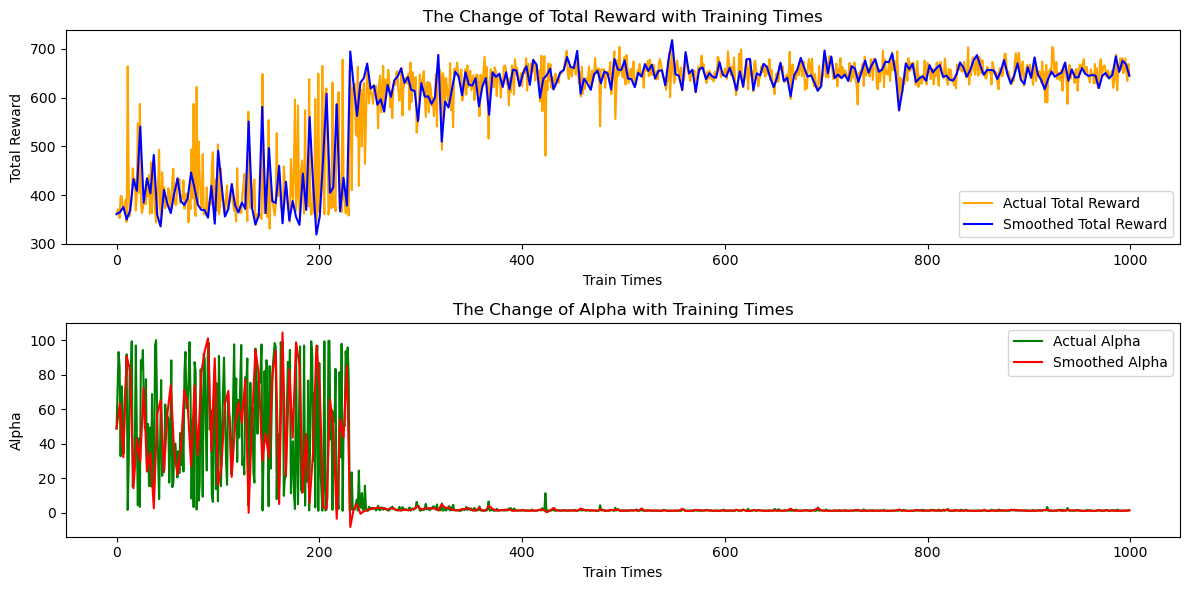

In [8]:
# 创建环境
np.random.seed(1)
probs = np.random.rand(10)
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)
env = MultiArmedBanditEnv(probs)
check_env(env)

# 创建模型
model = SAC("MlpPolicy", env, verbose=1)

# 自定义回调函数以记录 alpha 值和奖励
class AlphaCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(AlphaCallback, self).__init__(verbose)
        self.alphas = []
        self.rewards = []

    def _on_step(self) -> bool:
        # 确保 'action' 键存在于 self.locals 字典中
        if 'actions' in self.locals:
            action = self.locals['actions']
            self.alphas.append(action[0])
        # 记录奖励
        if 'rewards' in self.locals:
            reward = self.locals['rewards']
            self.rewards.append(reward)
        return True

# 创建 AlphaCallback 实例
alpha_callback = AlphaCallback()

# 训练模型并使用回调函数记录 alpha 值和奖励
model.learn(total_timesteps=1000, log_interval=4, callback=alpha_callback)

# 保存模型
model.save("sac_multi_armed_bandit")

# 假设 alphas 和 total_rewards 是在训练过程中记录的数据
alphas = alpha_callback.alphas
total_rewards = alpha_callback.rewards

# 创建平滑曲线函数
def smooth_curve(x, y):
    x_new = np.linspace(min(x), max(x), 300)
    spl = make_interp_spline(x, y, k=3)  # B-spline 拟合
    y_smooth = spl(x_new)
    return x_new, y_smooth


# 绘制 total_reward 的实际折线图和拟合的平滑曲线
plt.figure(figsize=(12, 6))

# 绘制 total_reward 的变化曲线
plt.subplot(2, 1, 1)
plt.plot(total_rewards, label='Actual Total Reward', color='orange')
x_smooth, y_smooth = smooth_curve(range(len(total_rewards)), total_rewards)
plt.plot(x_smooth, y_smooth, label='Smoothed Total Reward', color='blue')
plt.xlabel('Train Times')
plt.ylabel('Total Reward')
plt.title('The Change of Total Reward with Training Times')
plt.legend()

# 绘制 alpha 的变化曲线
plt.subplot(2, 1, 2)
plt.plot(alphas, label='Actual Alpha', color='green')
x_smooth, y_smooth = smooth_curve(range(len(alphas)), alphas)
plt.plot(x_smooth, y_smooth, label='Smoothed Alpha', color='red')
plt.xlabel('Train Times')
plt.ylabel('Alpha')
plt.title('The Change of Alpha with Training Times')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
smooth_count = 750  # 平滑数据点的数量
smooth_alphas = alphas[-smooth_count:] # 取最后 smooth_count 个数据点
smooth_total_rewards = total_rewards[-smooth_count:] # 取最后 smooth_count 个数据点
average_smooth_alphas = np.mean(smooth_alphas)  # 计算平均 alpha 值
average_smooth_total_rewards = np.mean(smooth_total_rewards)  # 计算平均奖励
print("最后 %d 个数据点的平均 alpha 值为：" % smooth_count, average_smooth_alphas)
print("最后 %d 个数据点的平均奖励为：" % smooth_count, average_smooth_total_rewards)

最后 750 个数据点的平均 alpha 值为： 1.4292909
最后 750 个数据点的平均奖励为： 645.26
